# Курсовой проект для курса "Библиотеки Python для Data Science: продолжение"

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Подключение библиотек
Импорт всех необходимых библиотек

In [178]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from catboost import CatBoostClassifier, Pool

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message='numpy.dtype size changed')
warnings.filterwarnings('ignore', message='numpy.ufunc size changed')

pd.set_option('display.max_rows', 50)

plt.style.use('fivethirtyeight')

sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Объявление вспомогательных функций

In [179]:
# функция рисует scatter-график по двум признакам
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

In [180]:
# функция составляет отчёт по проделанной классификации
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## Загрузка данных

In [181]:
TRAIN_DATASET_PATH = 'course_project/course_project_train.csv'
TEST_DATASET_PATH = 'course_project/course_project_test.csv'

In [182]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [183]:
df_train.shape

(7500, 17)

In [184]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [185]:
df_test.shape

(2500, 16)

## Обработка данных

### Посмотрим на целевую переменную

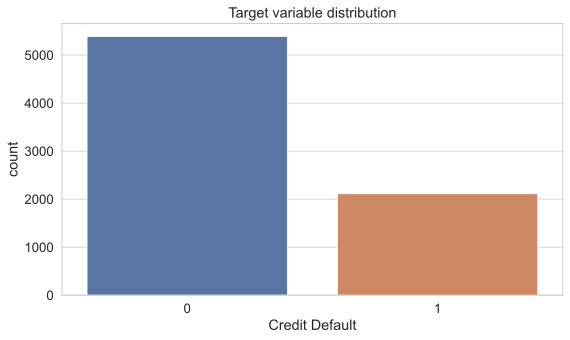

In [186]:
plt.figure(figsize=(8, 5))

sns.countplot(x='Credit Default', data=df_train)

plt.title('Target variable distribution')
plt.show()

### Посмотрим на остальные переменные

In [187]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [188]:
df_train.describe().T

count          mean           std       min  \
Annual Income                 5943.0  1.366392e+06  8.453392e+05  164597.0   
Tax Liens                     7500.0  3.013333e-02  2.716035e-01       0.0   
Number of Open Accounts       7500.0  1.113093e+01  4.908924e+00       2.0   
Years of Credit History       7500.0  1.831747e+01  7.041946e+00       4.0   
Maximum Open Credit           7500.0  9.451537e+05  1.602622e+07       0.0   
Number of Credit Problems     7500.0  1.700000e-01  4.985978e-01       0.0   
Months since last delinquent  3419.0  3.469260e+01  2.168881e+01       0.0   
Bankruptcies                  7486.0  1.171520e-01  3.471917e-01       0.0   
Current Loan Amount           7500.0  1.187318e+07  3.192612e+07   11242.0   
Current Credit Balance        7500.0  2.898332e+05  3.178714e+05       0.0   
Monthly Debt                  7500.0  1.831445e+04  1.192676e+04       0.0   
Credit Score                  5943.0  1.151087e+03  1.604451e+03     585.0   
Credit Default                7500.0  2.817333e-01  4.498740e-01       0.0   

                                   25%        50%         75%           max  
Annual Income                 844341.0  1168386.0  1640137.00  1.014934e+07  
Tax Liens                          0.0        0.0        0.00  7.000000e+00  
Number of Open Accounts            8.0       10.0       14.00  4.300000e+01  
Years of Credit History           13.5       17.0       21.80  5.770000e+01  
Maximum Open Credit           279229.5   478159.0   793501.50  1.304726e+09  
Number of Credit Problems          0.0        0.0        0.00  7.000000e+00  
Months since last delinquent      16.0       32.0       50.00  1.180000e+02  
Bankruptcies                       0.0        0.0        0.00  4.000000e+00  
Current Loan Amount           180169.0   309573.0   519882.00  1.000000e+08  
Current Credit Balance        114256.5   209323.0   360406.25  6.506797e+06  
Monthly Debt                   10067.5    16076.5    23818.00  1.366790e+05  
Credit Score                     711.0      731.0      743.00  7.510000e+03  
Credit Default                     0.0        0.0        1.00  1.000000e+00

In [189]:
df_train.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

Тоже самое для test-а

In [190]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [191]:
df_test.describe().T

count          mean           std       min  \
Annual Income                 1987.0  1.366922e+06  9.171252e+05  106533.0   
Tax Liens                     2500.0  3.520000e-02  3.862909e-01       0.0   
Number of Open Accounts       2500.0  1.118440e+01  4.852774e+00       1.0   
Years of Credit History       2500.0  1.832592e+01  7.254659e+00       3.9   
Maximum Open Credit           2500.0  7.105704e+05  1.511983e+06       0.0   
Number of Credit Problems     2500.0  1.620000e-01  5.598941e-01       0.0   
Months since last delinquent  1142.0  3.418126e+01  2.202428e+01       0.0   
Bankruptcies                  2497.0  1.069283e-01  3.571893e-01       0.0   
Current Loan Amount           2500.0  1.215572e+07  3.226097e+07   15422.0   
Current Credit Balance        2500.0  2.963966e+05  3.783020e+05       0.0   
Monthly Debt                  2500.0  1.827134e+04  1.154388e+04      93.0   
Credit Score                  1987.0  1.234517e+03  1.740219e+03     585.0   

                                    25%        50%        75%         max  
Annual Income                 852311.50  1178475.0  1629734.5  14975610.0  
Tax Liens                          0.00        0.0        0.0        15.0  
Number of Open Accounts            8.00       10.0       14.0        48.0  
Years of Credit History           13.40       17.0       22.1        53.4  
Maximum Open Credit           278586.00   478676.0   802598.5  54484386.0  
Number of Credit Problems          0.00        0.0        0.0        15.0  
Months since last delinquent      16.00       30.0       50.0        82.0  
Bankruptcies                       0.00        0.0        0.0         5.0  
Current Loan Amount           187126.50   322366.0   522582.5  99999999.0  
Current Credit Balance        110114.50   207385.0   366348.5   6030087.0  
Monthly Debt                   10024.75    16642.5    24146.0     93555.0  
Credit Score                     710.00      731.0      743.0      7480.0

In [192]:
df_test.nunique()

Home Ownership                     4
Annual Income                   1929
Years in current job              11
Tax Liens                          8
Number of Open Accounts           35
Years of Credit History          345
Maximum Open Credit             2435
Number of Credit Problems          8
Months since last delinquent      83
Bankruptcies                       6
Purpose                           14
Term                               2
Current Loan Amount             2026
Current Credit Balance          2385
Monthly Debt                    2416
Credit Score                     211
dtype: int64

### Обработка пустых значений

In [193]:
df_train.isna().sum()[df_train.isna().sum() != 0]

Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
dtype: int64

In [194]:
df_test.isna().sum()[df_train.isna().sum() != 0]

Annual Income                    513
Years in current job              86
Months since last delinquent    1358
Bankruptcies                       3
Credit Score                     513
dtype: int64

In [195]:
# Annual Income все пустые значения заполним медианой, на тесте также заполним медианой, но с трэйна
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
df_test['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)

In [196]:
# Years in current job все пустые значения заполним модой, на тесте также заполним модой, но с трэйна
year_mode = df_train['Years in current job'].mode().astype(str)[0]
df_train['Years in current job'].fillna(year_mode, inplace=True)
df_test['Years in current job'].fillna(year_mode, inplace=True)

In [197]:
# Months since last delinquent все пустые значения заполним модой, на тесте также заполним модой, но с трэйна
months_since_last_del_mode = df_train['Months since last delinquent'].mode()[0]
df_train['Months since last delinquent'].fillna(months_since_last_del_mode, inplace=True)
df_test['Months since last delinquent'].fillna(months_since_last_del_mode, inplace=True)

In [198]:
# Bankruptcies все пустые значения заполним модой, на тесте также заполним модой, но с трэйна
bankruptcies_mode = df_train['Bankruptcies'].mode()[0]
df_train['Bankruptcies'].fillna(bankruptcies_mode, inplace=True)
df_test['Bankruptcies'].fillna(bankruptcies_mode, inplace=True)

In [199]:
# Credit Score все пустые значения заполним модой, на тесте также заполним модой, но с трэйна
credit_score_mode = df_train['Credit Score'].mode()[0]
df_train['Credit Score'].fillna(credit_score_mode, inplace=True)
df_test['Credit Score'].fillna(credit_score_mode, inplace=True)

In [200]:
df_train.isna().sum()[df_train.isna().sum() != 0]

Series([], dtype: int64)

In [201]:
df_test.isna().sum()[df_train.isna().sum() != 0]

Series([], dtype: int64)

### Обработка выбросов

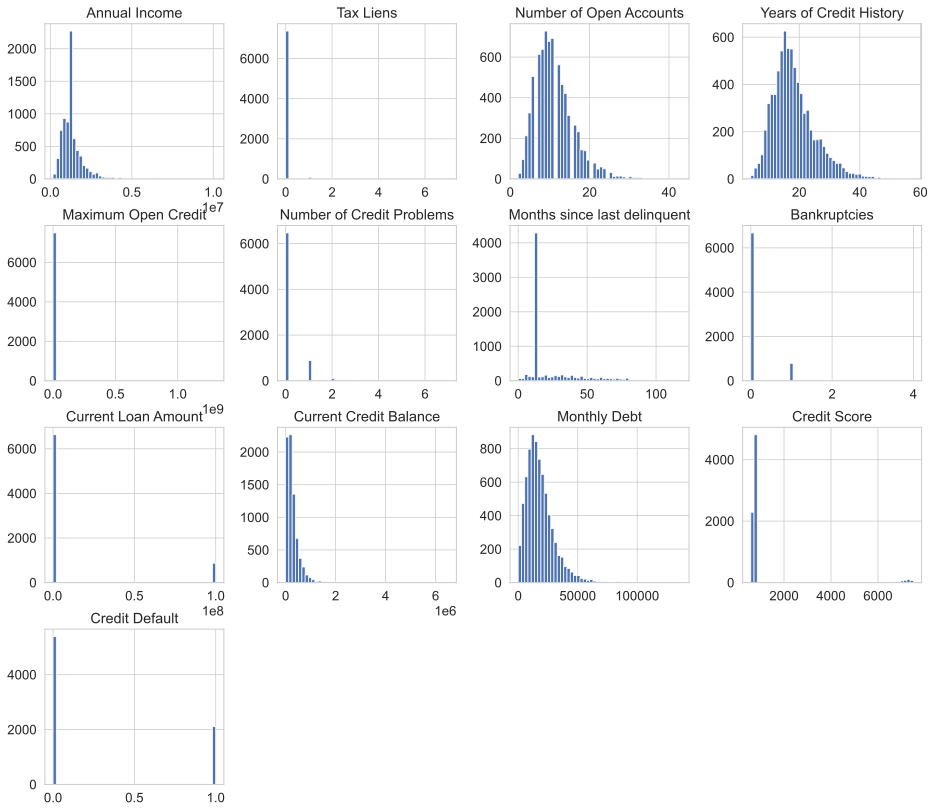

In [202]:
df_train.hist(figsize=(14,14), bins=50, grid=True);

#### Credit Score
Пока работал с пропусками в данном параметре, обратил внимание, что выбросы по данному параметру представляют собой ошибку в разрядности значения, т.е. вместо 680.0 записано 6800.0

In [203]:
df_train['Credit Score'].value_counts()

740.0     1726
747.0      168
748.0      157
745.0      152
741.0      151
          ... 
610.0        1
6820.0       1
619.0        1
6750.0       1
6670.0       1
Name: Credit Score, Length: 268, dtype: int64

In [204]:
df_train['Credit Score'].sort_values(ascending=False)

3688    7510.0
2213    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
3491     590.0
3475     589.0
1455     588.0
6114     586.0
599      585.0
Name: Credit Score, Length: 7500, dtype: float64

In [205]:
df_test['Credit Score'].value_counts()

740.0     563
746.0      56
739.0      55
741.0      54
745.0      49
         ... 
6800.0      1
6850.0      1
6310.0      1
6150.0      1
6670.0      1
Name: Credit Score, Length: 211, dtype: int64

In [206]:
df_test['Credit Score'].sort_values(ascending=False)

920     7480.0
2477    7480.0
1166    7480.0
227     7450.0
984     7450.0
         ...  
2270     598.0
2060     588.0
576      587.0
1163     586.0
1857     585.0
Name: Credit Score, Length: 2500, dtype: float64

Согласно официальным данным по кредитному рейтингу США https://www.usa.gov/credit-reports максимальное возможное значение - 850. Все значения выше этого параметра мы поделим на 10

In [207]:
df_train.loc[(df_train['Credit Score'] > 850), 'Credit Score'] = df_train['Credit Score']/10
df_test.loc[(df_test['Credit Score'] > 850), 'Credit Score'] = df_test['Credit Score']/10

Проверим, что после преобразования не получили значения меньше возможно допустимого кредитного рейтинга (300)

In [208]:
df_train['Credit Score'].sort_values(ascending=False)

2011    751.0
4326    751.0
1063    751.0
239     751.0
4500    751.0
        ...  
3491    590.0
3475    589.0
1455    588.0
6114    586.0
599     585.0
Name: Credit Score, Length: 7500, dtype: float64

In [209]:
df_test['Credit Score'].sort_values(ascending=False)

2075    751.0
505     751.0
879     751.0
1306    751.0
1257    751.0
        ...  
2270    598.0
2060    588.0
576     587.0
1163    586.0
1857    585.0
Name: Credit Score, Length: 2500, dtype: float64

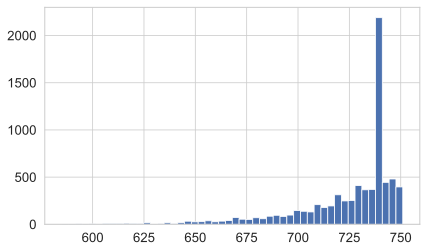

In [210]:
df_train['Credit Score'].hist(bins=50, grid=True);

#### Annual Income

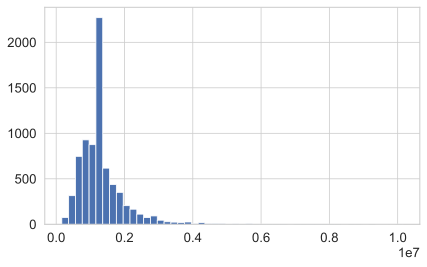

In [211]:
df_train['Annual Income'].hist(bins=50, grid=True);

In [212]:
df_train['Annual Income'].describe()

count    7.500000e+03
mean     1.325286e+06
std      7.567551e+05
min      1.645970e+05
25%      9.311330e+05
50%      1.168386e+06
75%      1.499974e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

In [213]:
df_test['Annual Income'].sort_values(ascending=False)

194     14975610.0
36      14934114.0
1089    10275770.0
1235     9163985.0
860      8057178.0
           ...    
2249      188233.0
1649      185782.0
2464      182609.0
372       163305.0
388       106533.0
Name: Annual Income, Length: 2500, dtype: float64

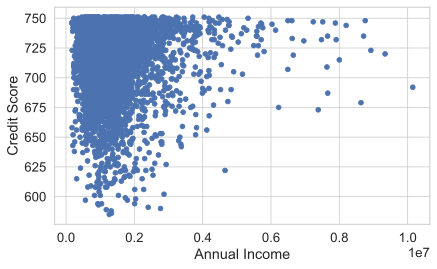

In [214]:
draw_scatter('Annual Income', 'Credit Score', df_train);

Избавимся от выбросов по правилу 3х сигм

In [215]:
mean_income = df_train['Annual Income'].mean()
sigma_income = df_train['Annual Income'].std()
df_train.loc[df_train['Annual Income'] > (mean_income + 3 * sigma_income), 'Annual Income'] = mean_income
df_test.loc[df_train['Annual Income'] > (mean_income + 3 * sigma_income), 'Annual Income'] = mean_income

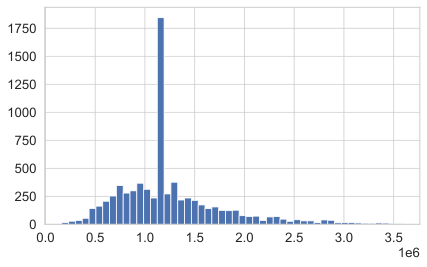

In [216]:
df_train['Annual Income'].hist(bins=50, grid=True);

#### Number of Open Accounts

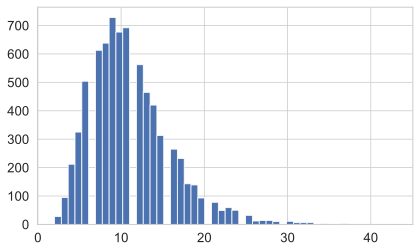

In [217]:
df_train['Number of Open Accounts'].hist(bins=50, grid=True);

Избавимся от выбросов по правилу 3х сигм

In [218]:
mean_noa = df_train['Number of Open Accounts'].mean()
sigma_noa = df_train['Number of Open Accounts'].std()
df_train.loc[df_train['Number of Open Accounts'] > (mean_noa + 3 * sigma_noa), 'Number of Open Accounts'] = mean_noa
df_test.loc[df_train['Number of Open Accounts'] > (mean_noa + 3 * sigma_noa), 'Number of Open Accounts'] = mean_noa

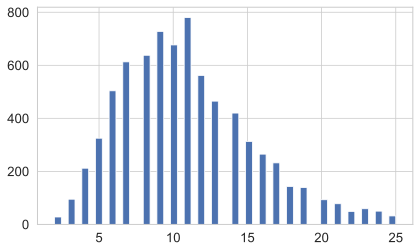

In [219]:
df_train['Number of Open Accounts'].hist(bins=50, grid=True);

#### Monthly Debt

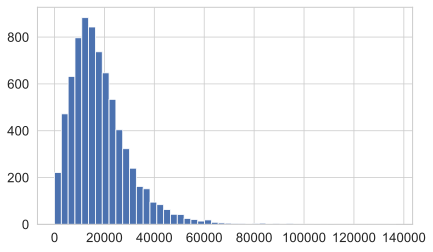

In [220]:
df_train['Monthly Debt'].hist(bins=50, grid=True);

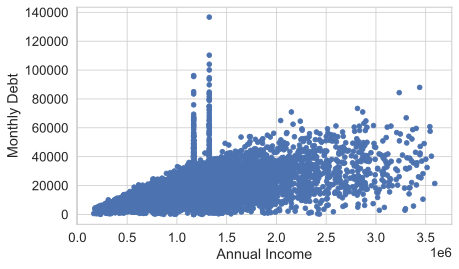

In [221]:
draw_scatter('Annual Income', 'Monthly Debt', df_train);

Очевидны выбросы, ежемесячный долг не должен превышать ежемесячного дохода, заменим значение ежемесячного долга в 43% от дохода (согласно https://www.consumerfinance.gov/ask-cfpb/what-is-a-debt-to-income-ratio-why-is-the-43-debt-to-income-ratio-important-en-1791/)

In [222]:
df_train.loc[df_train['Monthly Debt'] > (df_train['Annual Income'] / 12 * 0.43),
             'Monthly Debt'] = df_train['Annual Income'] / 12 * 0.43
df_test.loc[df_test['Monthly Debt'] > (df_test['Annual Income'] / 12 * 0.43),
             'Monthly Debt'] = df_test['Annual Income'] / 12 * 0.43

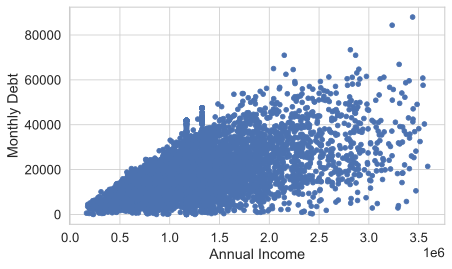

In [223]:
draw_scatter('Annual Income', 'Monthly Debt', df_train);

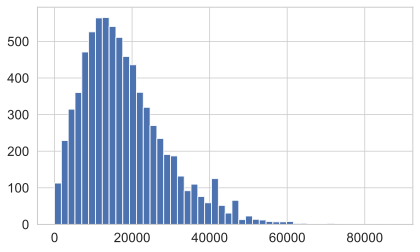

In [224]:
df_train['Monthly Debt'].hist(bins=50, grid=True);

#### Current Loan Amount 

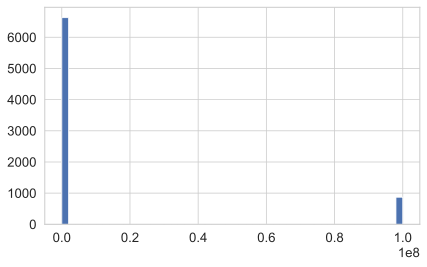

In [225]:
df_train['Current Loan Amount'].hist(bins=50, grid=True);

In [226]:
df_test['Current Loan Amount'].sort_values(ascending=False)

1249    99999999.0
1299    99999999.0
1359    99999999.0
2269    99999999.0
1333    99999999.0
           ...    
627        21692.0
1062       21670.0
1582       21648.0
1492       21450.0
426        15422.0
Name: Current Loan Amount, Length: 2500, dtype: float64

In [227]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [228]:
df_test['Current Loan Amount'].value_counts()

99999999.0    297
110462.0        3
396506.0        3
327404.0        3
258676.0        3
             ... 
543290.0        1
105578.0        1
43054.0         1
162448.0        1
450560.0        1
Name: Current Loan Amount, Length: 2026, dtype: int64

Значение в 99999999.0 имеют 870 записей, похоже на какие-то ошибки в данных, заменим медианой

In [229]:
df_train.loc[(df_train['Current Loan Amount'] == 99999999.0),
             'Current Loan Amount'] = df_train['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0),
             'Current Loan Amount'] = df_train['Current Loan Amount'].median()

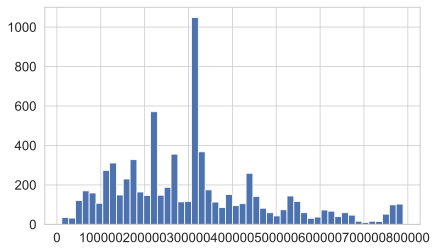

In [230]:
df_train['Current Loan Amount'].hist(bins=50, grid=True);

#### Current Credit Balance

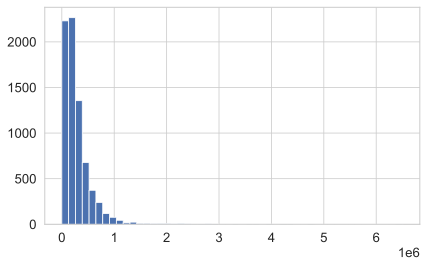

In [231]:
df_train['Current Credit Balance'].hist(bins=50, grid=True);

In [232]:
df_test['Current Credit Balance'].sort_values(ascending=False)

2152    6030087.0
228     5176018.0
285     4489054.0
253     4304051.0
2058    3962298.0
          ...    
1934          0.0
311           0.0
1343          0.0
2189          0.0
2199          0.0
Name: Current Credit Balance, Length: 2500, dtype: float64

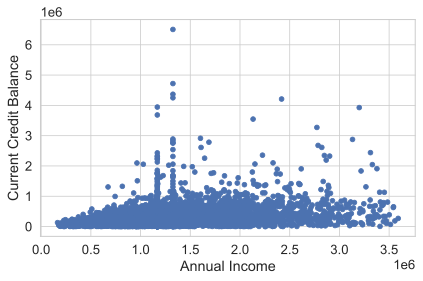

In [233]:
draw_scatter('Annual Income', 'Current Credit Balance', df_train);

Явно есть выбросы в данных. Т.к. не могу предположить зависимость между кредитным балансом и годовых доходом, то воспользуюсь правилом 3х сигм.

In [234]:
mean_ccb = df_train['Current Credit Balance'].mean()
sigma_ccb = df_train['Current Credit Balance'].std()
df_train.loc[df_train['Current Credit Balance'] > (mean_ccb + 3 * sigma_ccb), 'Current Credit Balance'] = mean_ccb
df_test.loc[df_train['Current Credit Balance'] > (mean_ccb + 3 * sigma_ccb), 'Current Credit Balance'] = mean_ccb

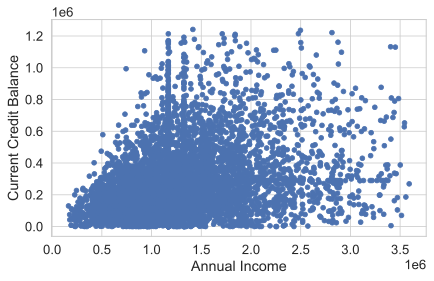

In [235]:
draw_scatter('Annual Income', 'Current Credit Balance', df_train);

Стало получше

#### Категориальные переменные
Посмотрим, что они из себя представляют. Каких либо изменений с ними не буду делать, так как буду использовать CatBoost, который работает с такими переменными без каких-либо преобразований.

In [236]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [237]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
df_test.loc[df_test['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

In [238]:
df_train['Years in current job'].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [239]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [240]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [241]:
df_train['Bankruptcies'].value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [242]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [243]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

## Выделение целевой переменной и групп признаков

In [244]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.tolist()
BASE_FEATURE_NAMES.remove(TARGET_NAME)

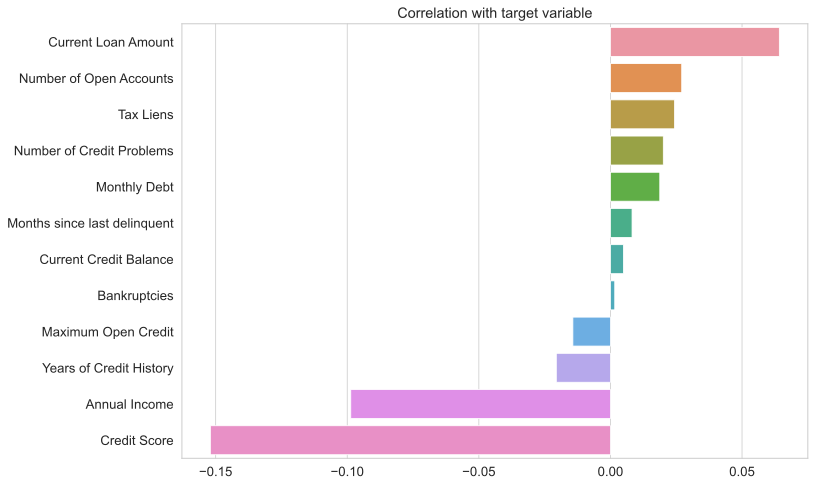

In [245]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

## Отбор признаков

In [246]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent',
                     'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                     'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

## Приведение типов для модели CatBoost

In [247]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = df_train[colname].astype(str)
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership               object
Years in current job         object
Tax Liens                    object
Number of Open Accounts      object
Number of Credit Problems    object
Bankruptcies                 object
Purpose                      object
Term                         object
dtype: object

In [248]:
for colname in CAT_FEATURE_NAMES:
    df_test[colname] = df_test[colname].astype(str)
    
df_test[CAT_FEATURE_NAMES].dtypes

Home Ownership               object
Years in current job         object
Tax Liens                    object
Number of Open Accounts      object
Number of Credit Problems    object
Bankruptcies                 object
Purpose                      object
Term                         object
dtype: object

## Нормализация данных

In [249]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

## Разбиение на train и на test

In [250]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=42)

In [251]:
model_catb = CatBoostClassifier(cat_features=CAT_FEATURE_NAMES, class_weights=[1, 3.5], silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.62      0.75      3795
           1       0.48      0.93      0.63      1455

    accuracy                           0.70      5250
   macro avg       0.72      0.77      0.69      5250
weighted avg       0.82      0.70      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.54      0.65      1592
           1       0.40      0.75      0.52       658

    accuracy                           0.60      2250
   macro avg       0.62      0.64      0.59      2250
weighted avg       0.71      0.60      0.61      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               852  740
1               165  493


## Подбор гиперпараметров

In [252]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 9],
          'border_count': [10, 20, 30],
          'learning_rate': [0.3, 0.4, 0.5, 0.6]}

In [253]:
cv=KFold(n_splits=3, random_state=42, shuffle=True)

In [254]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 884 ms, sys: 132 ms, total: 1.02 s
Wall time: 1min 40s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7ff96c601850>,
                   n_jobs=-1,
                   param_distributions={'border_count': [10, 20, 30],
                                        'learning_rate': [0.3, 0.4, 0.5, 0.6],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [255]:
rs.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.4, 'border_count': 20}

In [256]:
rs.best_score_

0.5096067659688731

## Обучение и оценка финальной модели

In [257]:
%%time

final_model = CatBoostClassifier(cat_features=CAT_FEATURE_NAMES, class_weights=[1, 3.5], silent=True, random_state=42,
                                n_estimators=50, max_depth=3, learning_rate=0.4, border_count=20)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.47      0.62      3795
           1       0.38      0.86      0.53      1455

    accuracy                           0.58      5250
   macro avg       0.64      0.67      0.57      5250
weighted avg       0.76      0.58      0.59      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.45      0.59      1592
           1       0.38      0.81      0.51       658

    accuracy                           0.55      2250
   macro avg       0.61      0.63      0.55      2250
weighted avg       0.71      0.55      0.57      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               718  874
1               128  530
CPU times: user 877 ms, sys: 129 ms, total: 1.01 s
Wall time: 292 ms


## Классификация

In [261]:
df_final_test = df_test[SELECTED_FEATURE_NAMES]

In [263]:
test_pred = final_model.predict(df_final_test)

In [269]:
test_pred.shape

(2500,)

In [266]:
preds = pd.DataFrame()
preds['Id'] = df_final_test.index
preds['Price'] = test_pred
preds.head()

Id  Price
0   0      1
1   1      1
2   2      1
3   3      1
4   4      1

In [270]:
preds.shape

(2500, 2)

In [267]:
preds.to_csv('DMFilippov_predictions.csv', index=False)